In [1]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader
from modules.constants import feature_list
from modules.data import GapFillingDataset
from modules.baseline import Baseline
from modules.gapt import GapT
from sklearn.impute import KNNImputer

In [2]:
output_dir = 'results/gapt_default_two_week_seq'

# Load metadata
with open(os.path.join(output_dir, 'metadata.json'), 'r') as f:
    metadata = json.load(f)

# Extract arguments from metadata
args = metadata['args']

# Initialize model from checkpoint
gapt_model = GapT.load_from_checkpoint(
    checkpoint_path=os.path.join(args['output_dir'], 'model.ckpt'),
    d_input=len(feature_list), 
    n_head=args['n_head'],
    d_feedforward=args['d_feedforward'],
    d_model=args['d_model'], 
    n_layers=args['n_layers'], 
    d_output=args['d_output'],
    learning_rate=args['learning_rate'],
    dropout_rate=args['dropout_rate'],
    optimizer=args['optimizer'],
    mode=args['mode'],
)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file results/gapt_default_two_week_seq/model.ckpt`


In [5]:
output_dir = 'results/baseline_two_week_seq'

# Load metadata
with open(os.path.join(output_dir, 'metadata.json'), 'r') as f:
    metadata = json.load(f)

# Extract arguments from metadata
args = metadata['args']

# Initialize model from checkpoint
baseline_model = Baseline.load_from_checkpoint(
    checkpoint_path=os.path.join(args['output_dir'], 'model.ckpt'),
    d_input=len(feature_list), 
    n_head=args['n_head'], 
    d_model=args['d_model'], 
    d_output=args['d_output'],
    d_embedding=args['d_embedding'],
    learning_rate=args['learning_rate'],
    dropout_rate=args['dropout_rate'],
    optimizer=args['optimizer'],
)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file results/baseline_two_week_seq/model.ckpt`


In [6]:
with open(os.path.join(args['data_dir'], 'paths.json'), 'r') as f:
    data_paths = json.load(f)

test_dataset = GapFillingDataset(data_paths['test'], metadata['feature_list'])
torch.manual_seed(42)
test_dataloader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)

### Calculate optimal number of neighbors for KNN

In [8]:
# Initialize a Dictionary to Store MSE for Each n_neighbors
mse_scores = {}

# Loop Over Possible n_neighbors Values
for n_neighbors in range(10, 11):
    
    # Loop Over Possible n_neighbors Values
    
    # Initialize KNN Imputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Initialize Accumulator for MSE
    total_mse = 0
    total_samples = 0
    
    # Loop Over Batches in Test DataLoader
    for batch in tqdm(test_dataloader):
        
        # Extract data from batch
        target = batch['target'].cpu().detach().numpy()
        mask = batch['mask'].cpu().detach().numpy()
        covariates = batch['covariates'].cpu().detach().numpy()
        
        inverted_mask = ~mask

        for idx in range(target.shape[0]):
            
            gap_indices = np.where(mask[idx] == False)
            knn_data = np.hstack([covariates[idx], target[idx].reshape(-1, 1)])
            knn_data[gap_indices[0], -1] = np.nan
            
            # Use KNN to Impute the Missing Values
            knn_imputed_data = imputer.fit_transform(knn_data)
            knn_imputed_values = knn_imputed_data[:, -1][:,np.newaxis]
            
            # Compute and Accumulate MSE
            mse = mean_squared_error(target[idx][inverted_mask[idx]], knn_imputed_values[inverted_mask[idx]])
            total_mse += mse
            total_samples += 1
    
    # Compute Average MSE for Current n_neighbors
    average_mse = total_mse / total_samples
    
    # Store the Average MSE for Current n_neighbors
    mse_scores[n_neighbors] = average_mse
    print("n_neighbors:", n_neighbors, "Average MSE:", average_mse)

# Select the Best n_neighbors Value

# Find the n_neighbors Value with Smallest Average MSE
best_n_neighbors = min(mse_scores, key=mse_scores.get)
print("Best n_neighbors:", best_n_neighbors, "with Minimum Average MSE:", mse_scores[best_n_neighbors])

  0%|          | 0/128 [00:00<?, ?it/s]

n_neighbors: 10 Average MSE: 0.5215888185583258
Best n_neighbors: 10 with Minimum Average MSE: 0.5215888185583258


### Calculate RMSE

In [ ]:
# Initialize Error Accumulators
baseline_mse_errors = []
gapt_mse_errors = []
knn_mse_errors = []

baseline_rmse_errors = []
gapt_rmse_errors = []
knn_rmse_errors = []

baseline_mae_errors = []
gapt_mae_errors = []
knn_mae_errors = []

baseline_mbe_errors = []
gapt_mbe_errors = []
knn_mbe_errors = []

# Set models to eval mode
baseline_model.eval()
gapt_model.eval()

# KNN Imputer
imputer = KNNImputer(n_neighbors=best_n_neighbors)

# Loop over batches
for batch in tqdm(test_dataloader):
    
    with torch.no_grad():
        baseline_predictions = baseline_model(batch)
        gapt_predictions = gapt_model(batch)
    
    target = batch['target'].cpu().detach().numpy()
    baseline_predictions = baseline_predictions.cpu().detach().numpy()
    gapt_predictions = gapt_predictions.cpu().detach().numpy()
    mask = batch['mask'].cpu().detach().numpy()
    covariates = batch['covariates'].cpu().detach().numpy()
    file = batch['file']
    
    inverted_mask = ~mask

    for idx in range(target.shape[0]):
        key = file[idx].split('/')[-1].split('.')[0].split('_')[0]
        
        true_values = np.exp(target[idx][inverted_mask[idx]])
        
        knn_imputed_data = imputer.fit_transform(knn_data)
        knn_imputed_values = knn_imputed_data[:, -1][:,np.newaxis]
        knn_pred = np.exp(knn_imputed_values[inverted_mask[idx]])
        
        baseline_pred = np.exp(baseline_predictions[idx][inverted_mask[idx]])
        gapt_pred = np.exp(gapt_predictions[idx][inverted_mask[idx]])

        # Accumulate MSE errors
        baseline_mse_errors.append(mean_squared_error(true_values, baseline_pred))
        gapt_mse_errors.append(mean_squared_error(true_values, gapt_pred))
        knn_mse_errors.append(mean_squared_error(true_values, knn_pred))
        
        # Accumulate RMSE errors
        baseline_rmse_errors.append(np.sqrt(mean_squared_error(true_values, baseline_pred)))
        gapt_rmse_errors.append(np.sqrt(mean_squared_error(true_values, gapt_pred)))
        knn_rmse_errors.append(np.sqrt(mean_squared_error(true_values, knn_pred)))

        # Accumulate MAE errors
        baseline_mae_errors.append(mean_absolute_error(true_values, baseline_pred))
        gapt_mae_errors.append(mean_absolute_error(true_values, gapt_pred))
        knn_mae_errors.append(mean_absolute_error(true_values, knn_pred))

        # Accumulate MBE errors
        baseline_mbe_errors.append(np.mean(baseline_pred - true_values))
        gapt_mbe_errors.append(np.mean(gapt_pred - true_values))
        knn_mbe_errors.append(np.mean(knn_pred - true_values))

# Calculate MSE Mean and Std
baseline_mse_mean, baseline_mse_std = np.mean(baseline_mse_errors), np.std(baseline_mse_errors)
gapt_mse_mean, gapt_mse_std = np.mean(gapt_mse_errors), np.std(gapt_mse_errors)
knn_mse_mean, knn_mse_std = np.mean(knn_mse_errors), np.std(knn_mse_errors)

# Calculate RMSE Mean and Std
baseline_rmse_mean, baseline_rmse_std = np.mean(baseline_rmse_errors), np.std(baseline_rmse_errors)
gapt_rmse_mean, gapt_rmse_std = np.mean(gapt_rmse_errors), np.std(gapt_rmse_errors)
knn_rmse_mean, knn_rmse_std = np.mean(knn_rmse_errors), np.std(knn_rmse_errors)

# Calculate MAE Mean and Std
baseline_mae_mean, baseline_mae_std = np.mean(baseline_mae_errors), np.std(baseline_mae_errors)
gapt_mae_mean, gapt_mae_std = np.mean(gapt_mae_errors), np.std(gapt_mae_errors)
knn_mae_mean, knn_mae_std = np.mean(knn_mae_errors), np.std(knn_mae_errors)

# Calculate MBE Mean and Std
baseline_mbe_mean, baseline_mbe_std = np.mean(baseline_mbe_errors), np.std(baseline_mbe_errors)
gapt_mbe_mean, gapt_mbe_std = np.mean(gapt_mbe_errors), np.std(gapt_mbe_errors)
knn_mbe_mean, knn_mbe_std = np.mean(knn_mbe_errors), np.std(knn_mbe_errors)

  0%|          | 0/128 [00:00<?, ?it/s]

In [14]:
# Print RMSE results
print("Baseline RMSE:", baseline_rmse_mean, "Std:", baseline_rmse_std)
print("Gapt RMSE:", gapt_rmse_mean, "Std:", gapt_rmse_std)
print("KNN RMSE:", knn_rmse_mean, "Std:", knn_rmse_std)
print('-----------------------------')
# Print MAE results
print("Baseline MAE:", baseline_mae_mean, "Std:", baseline_mae_std)
print("Gapt MAE:", gapt_mae_mean, "Std:", gapt_mae_std)
print("KNN MAE:", knn_mae_mean, "Std:", knn_mae_std)
print('-----------------------------')
# Print MBE results
print("Baseline MBE:", baseline_mbe_mean, "Std:", baseline_mbe_std)
print("Gapt MBE:", gapt_mbe_mean, "Std:", gapt_mbe_std)
print("KNN MBE:", knn_mbe_mean, "Std:", knn_mbe_std)

Baseline RMSE: 480.34763 Std: 546.54285
Gapt RMSE: 432.50726 Std: 509.32504
KNN RMSE: 785.49854 Std: 851.81616
-----------------------------
Baseline MAE: 371.5655 Std: 419.41824
Gapt MAE: 330.45493 Std: 383.34308
KNN MAE: 654.3473 Std: 726.9947
-----------------------------
Baseline MBE: -133.5048 Std: 421.6961
Gapt MBE: -78.484116 Std: 386.39804
KNN MBE: -435.7886 Std: 849.7481


In [ ]:
# Initialize a dictionary to store metrics per key
metrics_by_key = defaultdict(lambda: defaultdict(list))

# Set models to eval mode
baseline_model.eval()
gapt_model.eval()

# KNN Imputer
imputer = KNNImputer(n_neighbors=best_n_neighbors)

# Loop over batches
for batch in tqdm(test_dataloader):
    
    with torch.no_grad():
        baseline_predictions = baseline_model(batch)
        gapt_predictions = gapt_model(batch)
    
    target = batch['target'].cpu().detach().numpy()
    baseline_predictions = baseline_predictions.cpu().detach().numpy()
    gapt_predictions = gapt_predictions.cpu().detach().numpy()
    mask = batch['mask'].cpu().detach().numpy()
    file = batch['file']
    
    inverted_mask = ~mask

    for idx in range(target.shape[0]):
        key = file[idx].split('/')[-1].split('.')[0].split('_')[0]
        true_values = np.exp(target[idx][inverted_mask[idx]])
        
        knn_imputed_data = imputer.fit_transform(knn_data)
        knn_imputed_values = knn_imputed_data[:, -1][:,np.newaxis]
        knn_pred = np.exp(knn_imputed_values[inverted_mask[idx]])
        
        baseline_pred = np.exp(baseline_predictions[idx][inverted_mask[idx]])
        gapt_pred = np.exp(gapt_predictions[idx][inverted_mask[idx]])

        # Accumulate errors by key
        metrics_by_key[key]['baseline_mse'].append(mean_squared_error(true_values, baseline_pred))
        metrics_by_key[key]['gapt_mse'].append(mean_squared_error(true_values, gapt_pred))
        metrics_by_key[key]['knn_mse'].append(mean_squared_error(true_values, knn_pred))
        
        metrics_by_key[key]['baseline_rmse'].append(np.sqrt(mean_squared_error(true_values, baseline_pred)))
        metrics_by_key[key]['gapt_rmse'].append(np.sqrt(mean_squared_error(true_values, gapt_pred)))
        metrics_by_key[key]['knn_rmse'].append(np.sqrt(mean_squared_error(true_values, knn_pred)))

        metrics_by_key[key]['baseline_mae'].append(mean_absolute_error(true_values, baseline_pred))
        metrics_by_key[key]['gapt_mae'].append(mean_absolute_error(true_values, gapt_pred))
        metrics_by_key[key]['knn_mae'].append(mean_absolute_error(true_values, knn_pred))

        metrics_by_key[key]['baseline_mbe'].append(np.mean(baseline_pred - true_values))
        metrics_by_key[key]['gapt_mbe'].append(np.mean(gapt_pred - true_values))
        metrics_by_key[key]['knn_mbe'].append(np.mean(knn_pred - true_values))

In [13]:
# Now compute means and stds for each key and print them out
results_by_key = {}
for key, metrics in metrics_by_key.items():
    print(f'Metrics for station: {key}')
    results_by_key[key] = {}
    for metric_name, values in metrics.items():
        mean_val = np.mean(values)
        std_val = np.std(values)
        results_by_key[key][metric_name + "_mean"] = float(mean_val)  # Convert to native Python float
        results_by_key[key][metric_name + "_std"] = float(std_val)    # Convert to native Python float
        
        print(f'{metric_name}: Mean = {mean_val:.4f}, Std = {std_val:.4f}')
    
    print('-----------------------------')

# Save to JSON
with open("station_test_metrics.json", "w") as f:
    json.dump(results_by_key, f, indent=4)

Metrics for station: BSL
baseline_mse: Mean = 673939.1875, Std = 4621000.5000
gapt_mse: Mean = 554284.0625, Std = 4520719.5000
knn_mse: Mean = 1568802.0000, Std = 4810949.0000
baseline_rmse: Mean = 550.4304, Std = 609.0695
gapt_rmse: Mean = 468.7024, Std = 578.4481
knn_rmse: Mean = 1038.1761, Std = 700.7083
baseline_mae: Mean = 413.8025, Std = 311.4198
gapt_mae: Mean = 349.3440, Std = 273.0760
knn_mae: Mean = 834.5627, Std = 472.1302
baseline_mbe: Mean = -41.8342, Std = 408.0722
gapt_mbe: Mean = 40.3787, Std = 348.2410
knn_mbe: Mean = -766.5305, Std = 521.8676
-----------------------------
Metrics for station: HYY
baseline_mse: Mean = 129487.9062, Std = 344815.0938
gapt_mse: Mean = 88899.8594, Std = 214465.7031
knn_mse: Mean = 266483.6875, Std = 620027.1875
baseline_rmse: Mean = 280.5309, Std = 225.3671
gapt_rmse: Mean = 241.2442, Std = 175.2174
knn_rmse: Mean = 427.4127, Std = 289.4859
baseline_mae: Mean = 208.4286, Std = 174.1938
gapt_mae: Mean = 177.3592, Std = 134.4254
knn_mae: Mea

### Plot comparisons

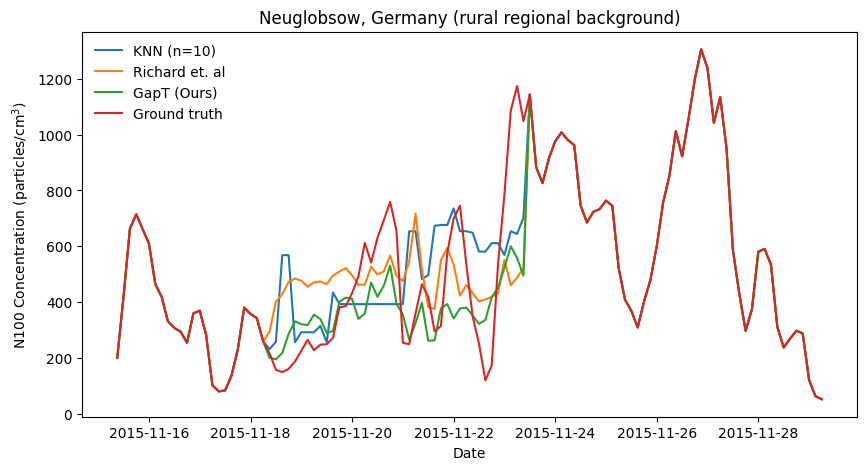

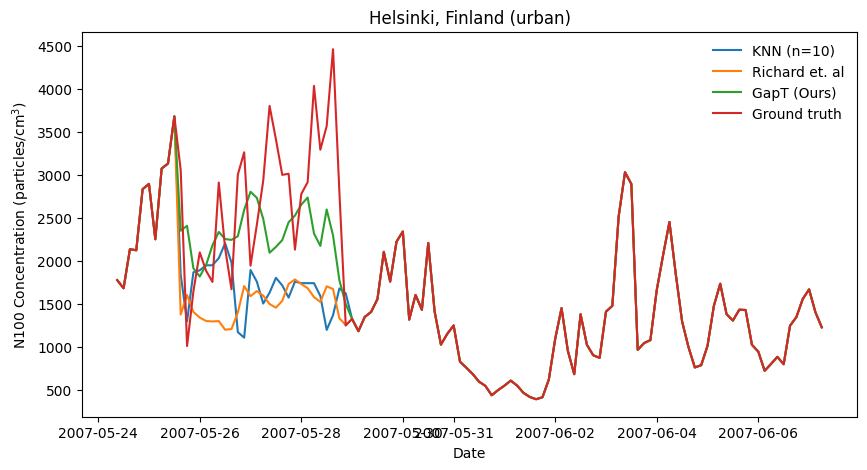

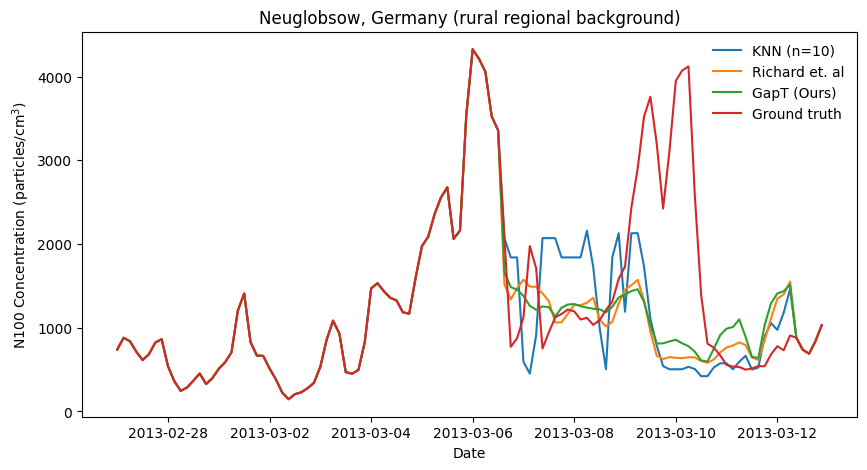

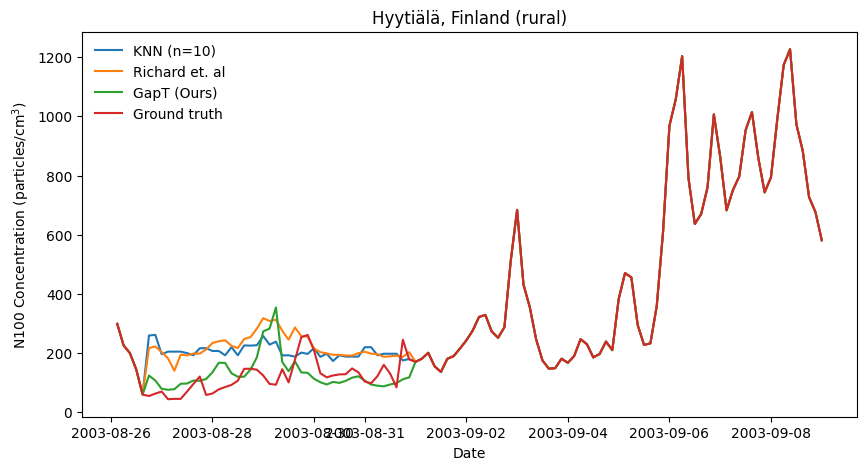

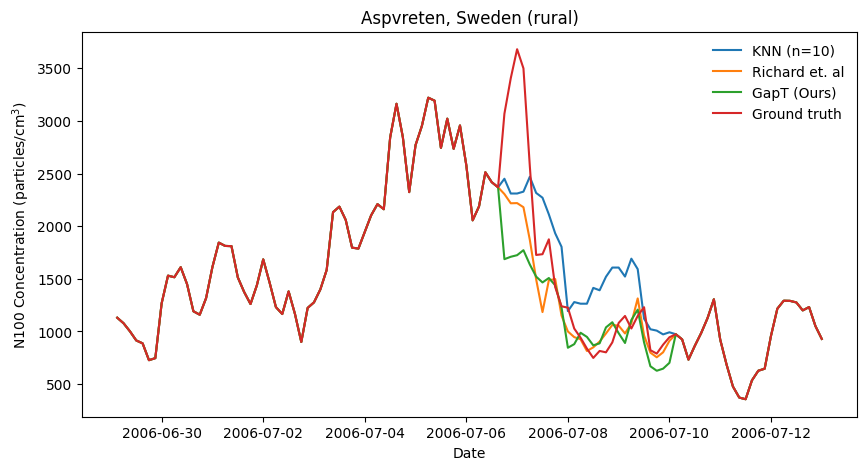

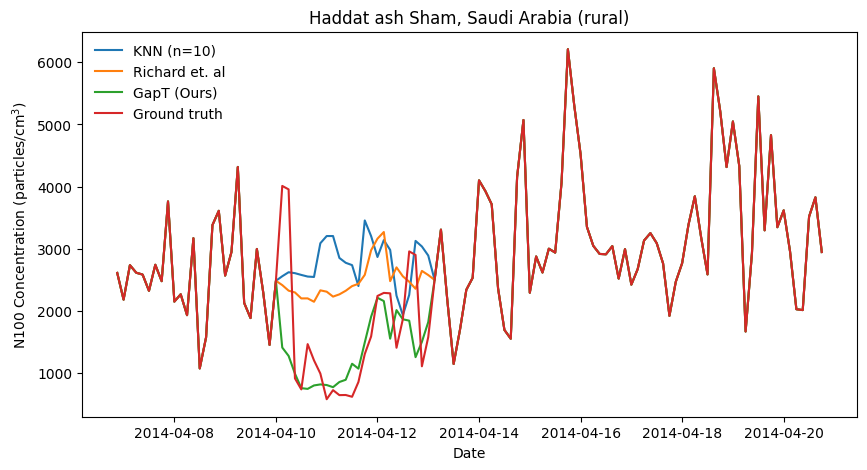

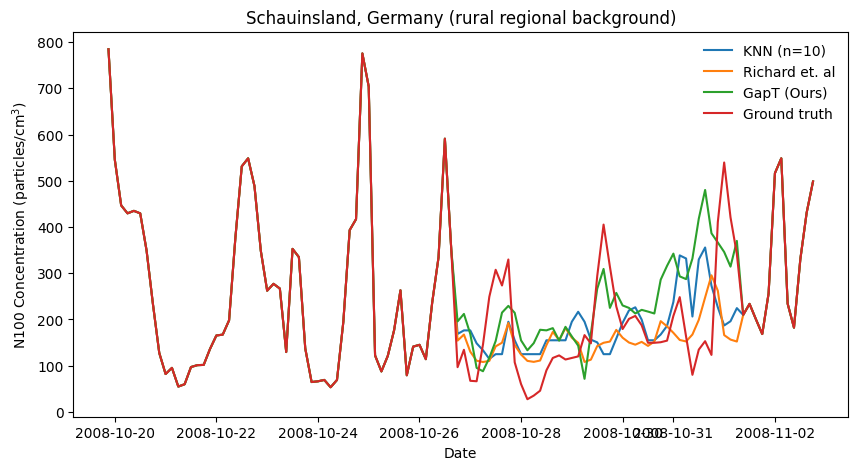

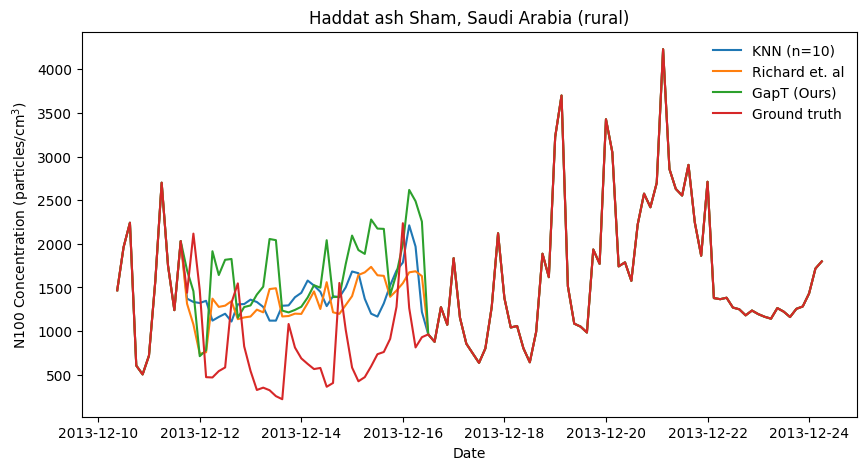

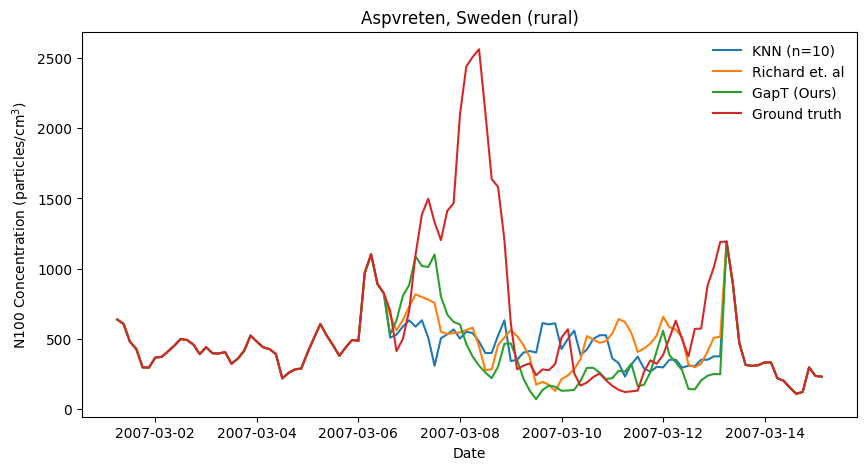

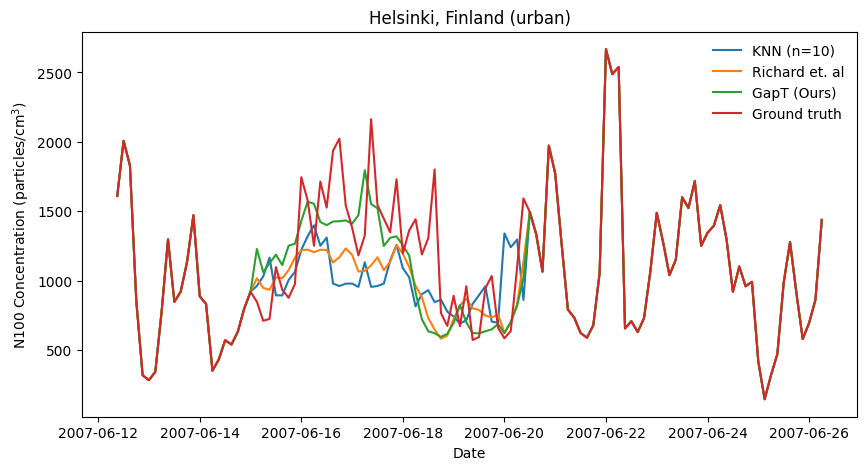

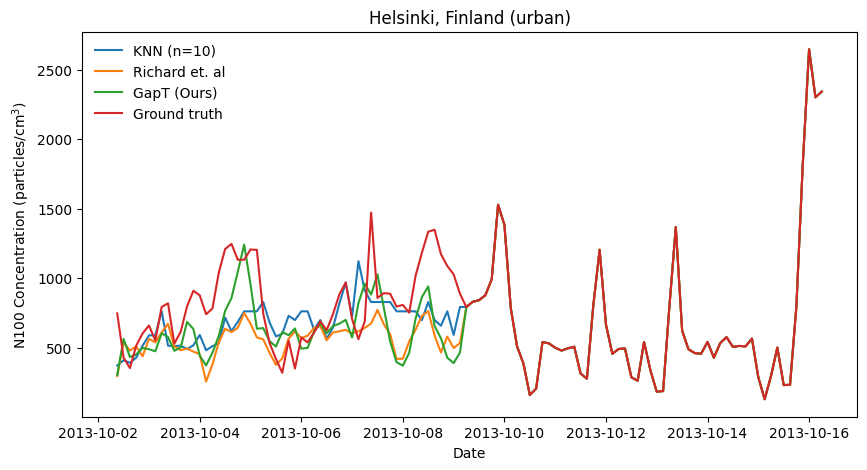

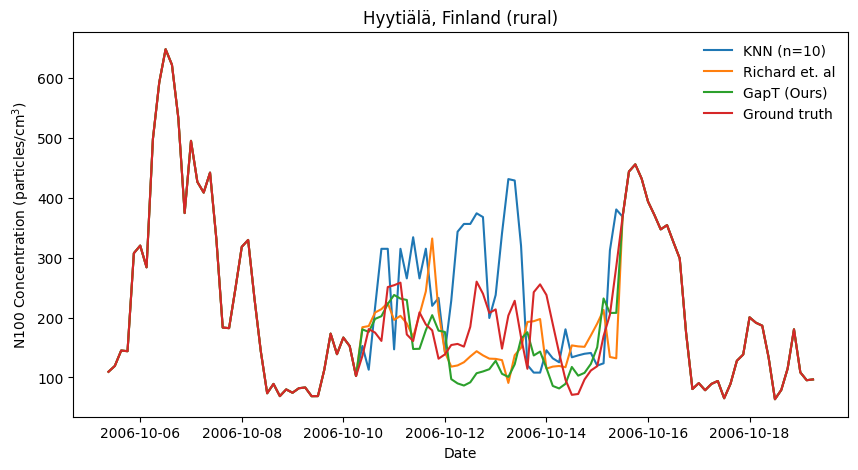

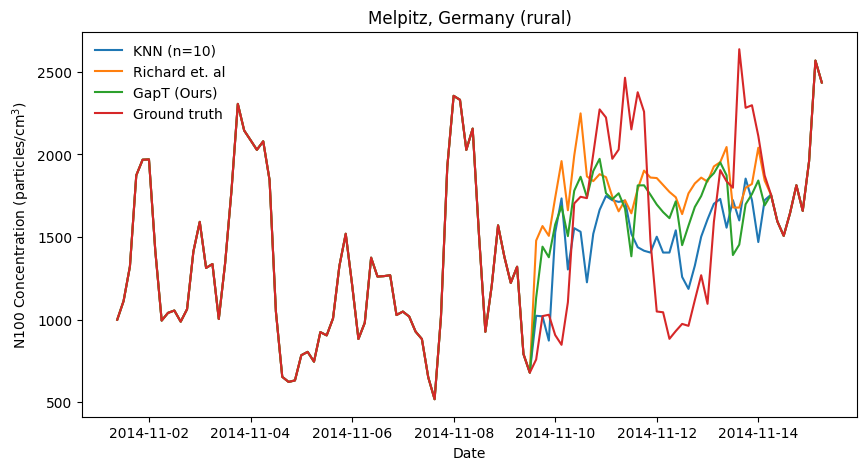

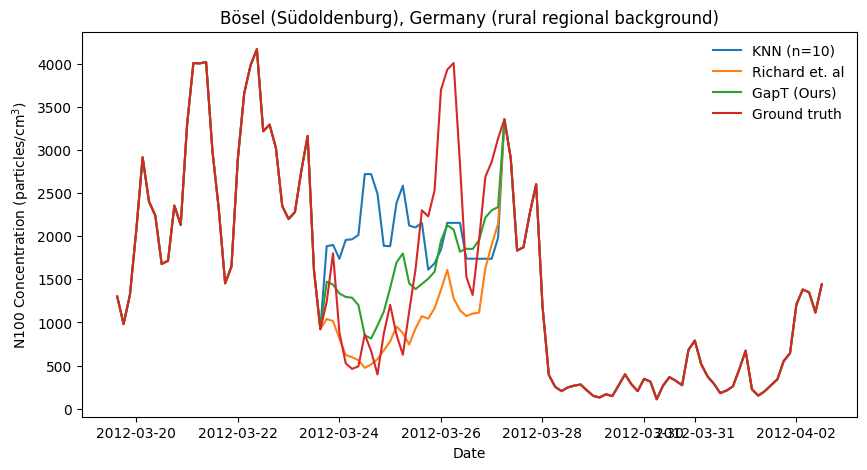

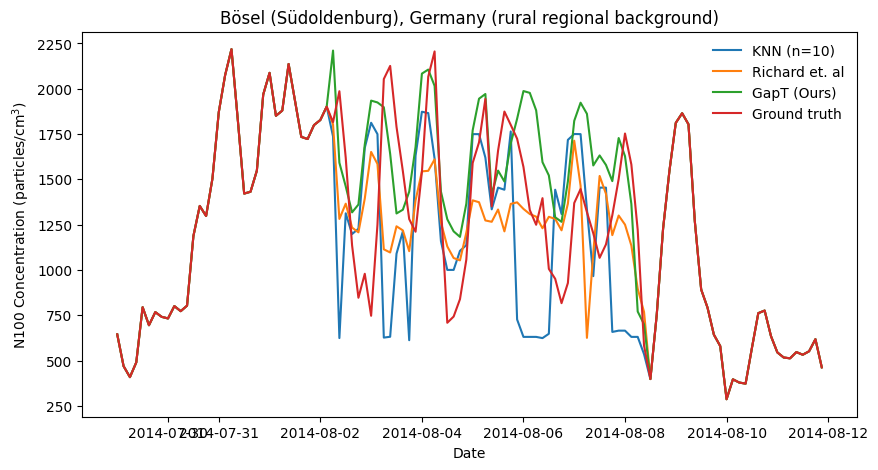

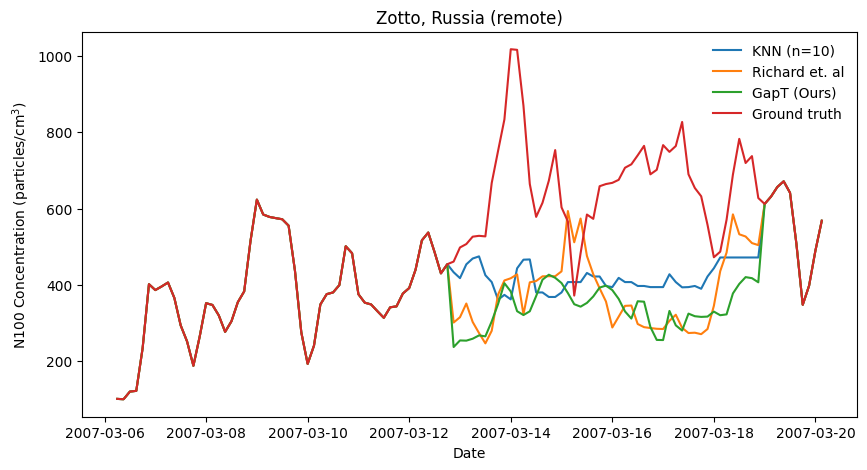

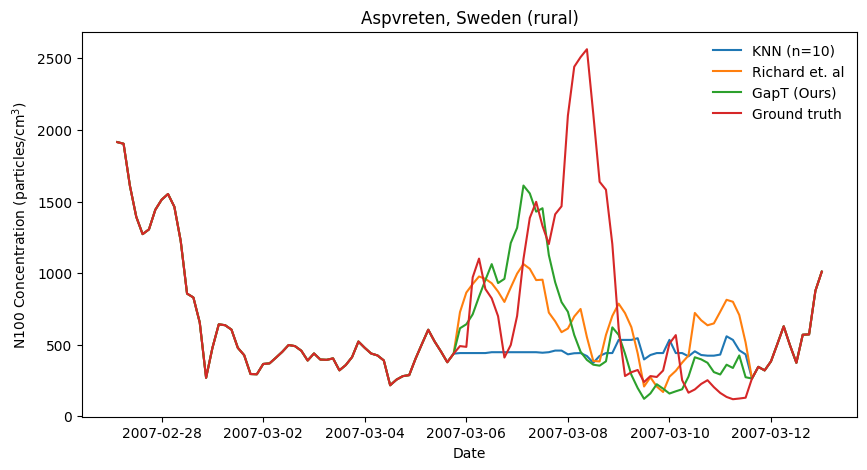

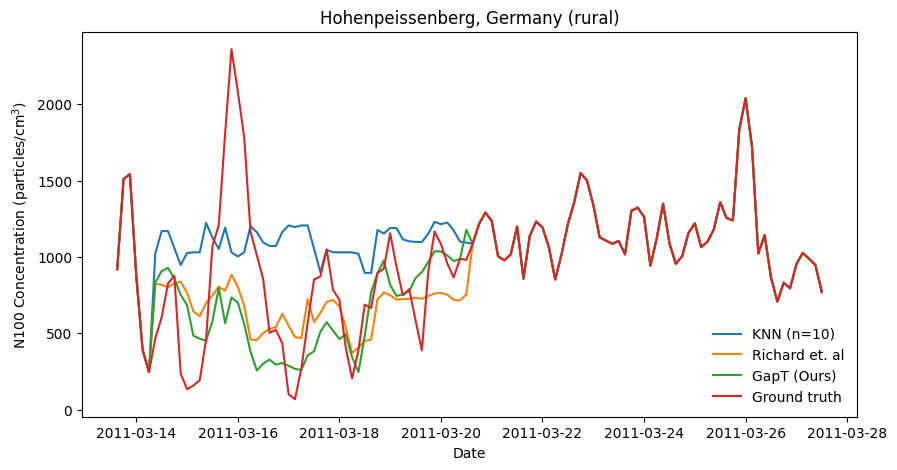

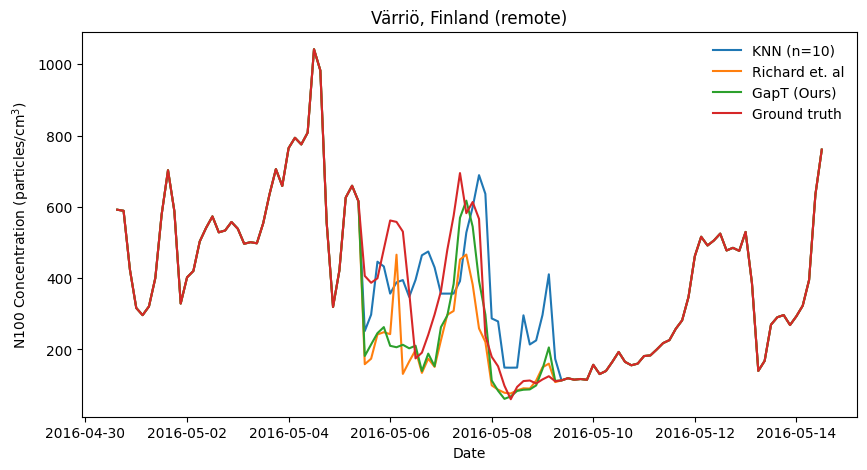

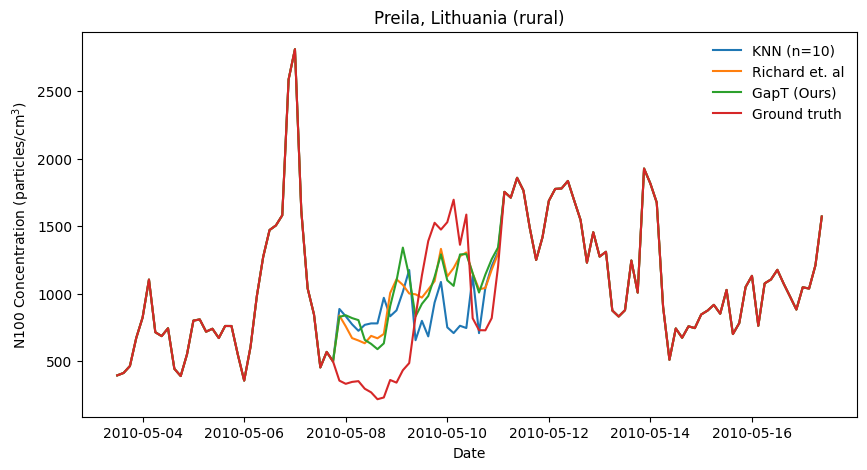

In [17]:
baseline_model.eval()
gapt_model.eval()

imputer = KNNImputer(n_neighbors=best_n_neighbors)

with open('data/measurement_sites.json', 'r') as file:
    measurement_sites = pd.read_json(file)

for batch in test_dataloader:
    
    with torch.no_grad():
        baseline_predictions = baseline_model(batch)
        gapt_predictions = gapt_model(batch)
    
    date = batch['unix_date'].cpu().detach().numpy()
    mask = batch['mask'].cpu().detach().numpy()
    target = batch['target'].cpu().detach().numpy()
    avg_target = batch['avg_target'].cpu().detach().numpy()
    baseline_predictions = baseline_predictions.cpu().detach().numpy()
    gapt_predictions = gapt_predictions.cpu().detach().numpy()
    observations = batch['target'].cpu().detach().numpy()
    covariates = batch['covariates'].cpu().detach().numpy()
    file = batch['file']

    for idx in range(0, 20):
        sample_date = pd.to_datetime(date[idx], unit='s')
        
        gap_indices = np.where(mask[idx] == False)

        # Preparing data matrix for KNN imputation
        knn_data = np.hstack([covariates[idx], target[idx].reshape(-1, 1)])
        knn_data[gap_indices[0], -1] = np.nan

        # Use KNN to impute the missing values
        knn_imputed_data = imputer.fit_transform(knn_data)
        knn_imputed_values = knn_imputed_data[:, -1]
        knn_imputed_values = knn_imputed_values[:, np.newaxis]
        
        key = file[idx].split('/')[-1].split('.')[0].split('_')[0]
        
        station_name = measurement_sites[key]['station_name']
        environment_type = ' '.join(measurement_sites[key]['environment_type'].split('_'))

        plt.figure(figsize=(10, 5))
        plt.plot(sample_date, np.exp(knn_imputed_values), label=f'KNN (n={best_n_neighbors})')
        plt.plot(sample_date, np.exp(baseline_predictions[idx]), label='Richard et. al')
        plt.plot(sample_date, np.exp(gapt_predictions[idx]), label='GapT (Ours)')
        plt.plot(sample_date, np.exp(target[idx]), label='Ground truth')
        plt.xlabel('Date')
        plt.ylabel(r'N100 Concentration (particles/cm$^3$)')
        plt.title(f'{station_name} ({environment_type})')
        plt.legend(frameon=False)
        plt.show()

    break